In [1]:
import keras.backend as K
from keras.layers import Input, Add, Dense, Activation, Flatten, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D, TimeDistributed
from keras.models import Model
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.constraints import max_norm
from keras.layers.noise import GaussianNoise
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import matplotlib.pyplot as plt
import config
import importlib
import os
import numpy as np
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

nb_classes = C.nb_classes

X_train = np.expand_dims(x_train,axis=3)
X_train = np.expand_dims(X_train,axis=4)
X_test = np.expand_dims(x_test,axis=3)
X_test = np.expand_dims(X_test,axis=4)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [2]:
importlib.reload(config)

<module 'config' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\config.py'>

In [141]:
C = config.Config()
dims = C.dims
voi_img = Input(shape=(dims[0], dims[1], dims[2], C.nb_channels))
#x = Dropout(0.2)(voi_img)
#x = GaussianNoise(1)(x)
#x = ZeroPadding3D(padding=(3,3,2))(voi_img)
#x = Conv3D(filters=128, kernel_size=(3,3,2), activation='relu', kernel_regularizer=l2(.01))(x)
x = Conv3D(filters=32, kernel_size=(3,3,1), activation='relu')(voi_img)
x = Conv3D(filters=64, kernel_size=(3,3,1), activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dropout(0.2)(x)
intermed = MaxPooling3D((2, 2, 2))(x)
x = Flatten()(intermed)
x = Dense(128, activation='relu')(x)#, kernel_initializer='normal', kernel_regularizer=l1(.01), kernel_constraint=max_norm(3.))(x)
x = Dropout(0.5)(x)
pred_class = Dense(C.nb_classes, activation='softmax')(x)#Dense(C.nb_classes, activation='softmax')(x)

In [142]:
optim = Adam(lr=0.01)#, decay=0.001)
early_stopping = EarlyStopping(min_delta=0.01, patience=5)

model = Model(voi_img, pred_class)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 20, 20, 10, 2)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 18, 18, 10, 32)    608       
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 16, 16, 10, 64)    18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 10, 64)    0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 8, 8, 5, 64)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 20480)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               2621568   
__________

In [5]:
model2 = Model(voi_img, intermed)

for l in range(2,len(model2.layers)):
    model2.layers[l].set_weights(model.layers[l].get_weights())

X_train = []
Y_train = []

for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    Y_train.append([1,0])
for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    X_train[-1][5:15,5:15,5:7,0] = 2
    Y_train.append([0,1])
    
X_train = np.array(X_train) # X[:total_size//2]
#X_val = np.array(X_test)
Y_train = np.array(Y_train) # Y[:total_size//2]
#Y_val = np.array(Y_test)

In [123]:
data_dict = {}
max_samples = {}
base_dir = "..\\liver-mr-processor\\train_imgs\\"

least_in_one_class = np.Inf

for class_name in os.listdir(base_dir):
    x = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    for index, img_fn in enumerate(os.listdir(base_dir+class_name)):
        x[index] = np.load(base_dir+class_name+"\\"+img_fn)
        z.append(img_fn)
    
    x.resize((index, dims[0], dims[1], dims[2], C.nb_channels))
    data_dict[class_name] = [x,np.array(z)]
    max_samples[class_name] = index
    
    least_in_one_class = min(index, least_in_one_class)

In [134]:
Z_cyst = data_dict["cyst"][1]

In [136]:
Y_[-4]

array([ 0.47784024,  0.52215981], dtype=float32)

In [145]:
Z_cyst[-4]

'E100529980_0.npy'

In [124]:
X_cyst = data_dict["cyst"][0]
X_cyst = np.array(X_cyst) # X[:total_size//2]
X_cyst /= 255

In [125]:
X_hcc = data_dict["hcc"][0]
X_hcc = np.array(X_hcc) # X[:total_size//2]
X_hcc /= 255

In [114]:
X_train = []
Y_train = []
Z_train = []
X_test = []
Y_test = []
Z_test = []
#train_frac = 0.75
cls_mapping = []

for cls_num, cls in enumerate(data_dict):
    if cls == "cyst":
        train_frac = 1.4
    else:
        train_frac = 0.8
    #order = np.random.permutation(list(range(max_samples)))
    order = list(range(max_samples[cls]))
    X_train = X_train + list(data_dict[cls][0][order[:round(least_in_one_class*train_frac)]])
    X_test = X_test + list(data_dict[cls][0][order[round(least_in_one_class*train_frac):]])
    Z_train = Z_train + list(data_dict[cls][1][order[:round(least_in_one_class*train_frac)]])
    Z_test = Z_test + list(data_dict[cls][1][order[round(least_in_one_class*train_frac):]])
    Y_train = Y_train + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * (round(least_in_one_class*train_frac))
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (max_samples[cls] - round(least_in_one_class*train_frac))
        
    cls_mapping.append(cls)

In [115]:
X_train = np.array(X_train) # X[:total_size//2]
X_train /= 255
X_val = np.array(X_test)
X_val /= 255
#X_val = X[total_size//2:total_size*3//4]
#X_test = X[total_size*3//4:]
Y_train = np.array(Y_train)
Y_val = np.array(Y_test)
Z_train = np.array(Z_train)
Z_val = np.array(Z_test)
#Y_val = Y[total_size//2:total_size*3//4]
#Y_test = Y[total_size*3//4:]

In [116]:
len(Z_train)/30

21.933333333333334

In [117]:
len(Z_val)/30

11.0

In [42]:
#X = np.array([z for z in x])
#Y = np.array(y)
#Y = np.array([[0,1] if y[x] == 1 else [1,0] for x in range(len(y))])
#Y = K.constant(y, dtype=tf.int32)
#Y = K.one_hot(Y, C.nb_classes)

#total_size = X.shape[0]

#order = np.random.permutation(list(range(total_size)))
#X = X[order]
#Y = Y[order]

def train_generator(X, Y):
    while True:
        for i in range(len(X)):
            yield np.expand_dims(X[i], axis=0), np.expand_dims(Y[i], axis=0)

num_epochs = 10
epoch_length = 100
best_loss = np.Inf
losses = np.zeros(epoch_length)
acc = np.zeros(epoch_length)

data_gen_train = train_generator(X_train, Y_train)
for epoch_num in range(num_epochs):
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
    iter_num = 0
    
    while True:
        X, Y = next(data_gen_train)
        losses[iter_num], acc[iter_num] = model.train_on_batch(X, Y)

        iter_num += 1
        if iter_num == epoch_length:
            curr_loss = np.mean(losses)
            curr_acc = np.mean(acc)
            print("Mean Loss:", curr_loss, "// Mean Accuracy:", curr_acc)

            if curr_loss < best_loss:
                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model.save_weights(C.model_path)
            break

In [143]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=200, validation_data=(X_val, Y_val)) #callbacks=[early_stopping]

Train on 658 samples, validate on 330 samples
Epoch 1/200
658/658 [==============================] - 1s - loss: 0.7848 - acc: 0.5350 - val_loss: 0.5602 - val_acc: 0.8182
Epoch 2/200
658/658 [==============================] - 0s - loss: 0.6343 - acc: 0.6581 - val_loss: 0.4769 - val_acc: 0.8182
Epoch 3/200
658/658 [==============================] - 0s - loss: 0.4798 - acc: 0.7401 - val_loss: 0.6404 - val_acc: 0.6727
Epoch 4/200
658/658 [==============================] - 0s - loss: 0.4194 - acc: 0.7994 - val_loss: 0.5685 - val_acc: 0.8212
Epoch 5/200
658/658 [==============================] - 0s - loss: 0.3721 - acc: 0.8116 - val_loss: 0.7230 - val_acc: 0.8212
Epoch 6/200
658/658 [==============================] - 0s - loss: 0.3474 - acc: 0.8435 - val_loss: 0.5105 - val_acc: 0.8667
Epoch 7/200
658/658 [==============================] - 0s - loss: 0.3031 - acc: 0.8480 - val_loss: 0.4781 - val_acc: 0.8212
Epoch 8/200
658/658 [==============================] - 0s - loss: 0.2345 - acc: 0.9088

658/658 [==============================] - 0s - loss: 0.0088 - acc: 1.0000 - val_loss: 0.1153 - val_acc: 0.9394
Epoch 67/200
658/658 [==============================] - 0s - loss: 0.0080 - acc: 1.0000 - val_loss: 0.0758 - val_acc: 0.9848
Epoch 68/200
658/658 [==============================] - 0s - loss: 0.0101 - acc: 1.0000 - val_loss: 0.0736 - val_acc: 0.9788
Epoch 69/200
658/658 [==============================] - 0s - loss: 0.0077 - acc: 0.9985 - val_loss: 0.0791 - val_acc: 0.9758
Epoch 70/200
658/658 [==============================] - 0s - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0890 - val_acc: 0.9697
Epoch 71/200
658/658 [==============================] - 0s - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9788
Epoch 72/200
658/658 [==============================] - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9758
Epoch 73/200
658/658 [==============================] - 0s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9758
Epoch 74/200


658/658 [==============================] - 0s - loss: 0.0071 - acc: 0.9985 - val_loss: 0.0183 - val_acc: 1.0000
Epoch 132/200
658/658 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9879
Epoch 133/200
658/658 [==============================] - 0s - loss: 0.0118 - acc: 0.9985 - val_loss: 0.0703 - val_acc: 0.9727
Epoch 134/200
658/658 [==============================] - 0s - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0740 - val_acc: 0.9727
Epoch 135/200
658/658 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0676 - val_acc: 0.9758
Epoch 136/200
658/658 [==============================] - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0922 - val_acc: 0.9545
Epoch 137/200
658/658 [==============================] - 0s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.1114 - val_acc: 0.9455
Epoch 138/200
658/658 [==============================] - 0s - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0776 - val_acc: 0.9697
Epoch 

658/658 [==============================] - 0s - loss: 0.0080 - acc: 1.0000 - val_loss: 0.1720 - val_acc: 0.9394
Epoch 197/200
658/658 [==============================] - 0s - loss: 0.0079 - acc: 1.0000 - val_loss: 0.1941 - val_acc: 0.9303
Epoch 198/200
658/658 [==============================] - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.1065 - val_acc: 0.9485
Epoch 199/200
658/658 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0244 - val_acc: 0.9939
Epoch 200/200
658/658 [==============================] - 0s - loss: 0.0035 - acc: 0.9985 - val_loss: 0.0265 - val_acc: 0.9939


In [127]:
model.predict(X_cyst)

array([[  4.70719121e-15,   1.00000000e+00],
       [  5.68544777e-14,   1.00000000e+00],
       [  1.99857548e-18,   1.00000000e+00],
       [  1.62834822e-05,   9.99983668e-01],
       [  2.65297940e-11,   1.00000000e+00],
       [  3.26242852e-12,   1.00000000e+00],
       [  4.11501969e-06,   9.99995828e-01],
       [  1.92551225e-10,   1.00000000e+00],
       [  6.02835673e-04,   9.99397159e-01],
       [  2.27131158e-09,   1.00000000e+00],
       [  4.50570951e-05,   9.99954939e-01],
       [  5.96788668e-05,   9.99940276e-01],
       [  5.31585003e-14,   1.00000000e+00],
       [  6.96933782e-08,   9.99999881e-01],
       [  1.58653242e-13,   1.00000000e+00],
       [  1.53077719e-26,   1.00000000e+00],
       [  2.25973595e-02,   9.77402627e-01],
       [  4.77840245e-01,   5.22159815e-01],
       [  2.87815639e-11,   1.00000000e+00],
       [  1.31480746e-28,   1.00000000e+00],
       [  1.57597730e-12,   1.00000000e+00],
       [  1.88092380e-12,   1.00000000e+00]], dtype=flo

In [159]:
activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

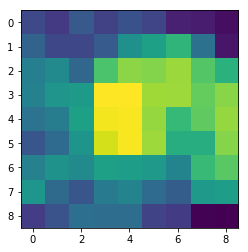

In [166]:
plt.imshow(activ[20][:,:,3,5])

In [162]:
activ[0][5,5,2,:]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  121.71251678,   53.23372269,    0.        ,
          0.        ,   24.43340492,    0.        ,    0.        ,
          0.        ,    0.        ,    7.88301706,    0.        ], dtype=float32)

In [113]:
Z_val[::30]

array(['12296182_23.npy', '13028374_2.npy', 'E104657225_14.npy',
       '12972894_6.npy'],
      dtype='<U17')

In [133]:
Y_[-5]

array([ 0.47784024,  0.52215981], dtype=float32)

In [144]:
import operator
#print("Ground truth:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_cyst)
print("Predictions:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% confidence)" % (max(x)*100) for x in Y_])

Predictions: ['cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.99998% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.99858% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.99996% confidence)', 'cyst (99.99999% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (99.60698% confidence)', 'hcc (70.35562% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)', 'cyst (100.00000% confidence)']


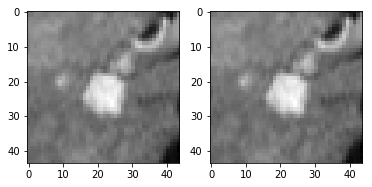

In [147]:
import pandas as pd
voi_df = pd.read_csv('..\\liver-mr-processor\\vois.csv')
img_fn = "12972894.npy"
img = np.load("..\\liver-mr-processor\\full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=15)

In [136]:
def plot_section(img, df, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')
    plt.subplot(122)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 1], (1,0)), cmap='gray')

In [20]:
Y_[-1]

array([  2.78843247e-04,   9.99721110e-01], dtype=float32)

In [19]:
max(sum(y)/len(y), 1-sum(y)/len(y))

0.6875

In [87]:
len(X_val)

210

In [84]:
import time

In [86]:
a=time.time()
Y_ = model.predict(X_val)
print(time.time()-a)

0.20054101943969727


In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
np.amax(X[650,:,:,:,0])

0.0

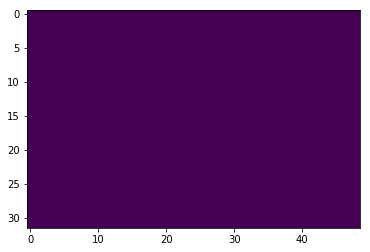

In [140]:
plt.imshow(X[0,:,:,5,0])